York Solutions | AML BB Cohort 2023-2024
Final Capstone Project - Customer Propensity "Add to Cart" Event Action

This assignment is to design, build, evaluate, and deploy a Machine Learning model to predict customer propensity to perform the "Add to Cart" action. The model should accurately predict whether this action will be performed or not based on the features selected or developed from the given dataset. This model is essential as part of the Q2 business goal to increase the return on ad-spending of the company employing google analytics. 

Using google analytics 360 sample dataset on BigQuery, develop, and deploy a model in VertexAI to predict when a 'hit' will have an event action of "Add to Cart". To start with, a 1-month period of my choice should be used to train the model, with the goal of being able to easily substitute in the 12-month period (full dataset) after validating the model. Because of the dataset size, it is assumed that data cleaning and feature selection will take place to test and train the modle in a timely manner. 



In [1]:
## Allowed dependencies for this project that could still be included:
## SciPy
## Google-cloud-*

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel

import copy            # able to deep-copy dictionaries for row iteration and dataframe modification processes
import warnings        # suppressing warnings that keep taking up space during my code executions



Data Exploration and Pre-Processing:


3. Perform Exploratory Data Analysis to understand the structure, distribution, and characteristics of the data
4. Convert categorical variables into numerical representations if needed (e.g., one-hot encoding)
5. Split the data into training and test sets


In [2]:
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

BQ_LOCATION = 'US'
REGION = 'us-east-1'

In [3]:
%%bigquery selectData_bq_df --project $PROJECT_ID
SELECT 
concat(fullVisitorId, visitId) AS session_id,
visitNumber, CAST(SUBSTRING(`date`,5,2) AS int) AS month,
CAST(SUBSTRING(`date`,7,2) AS int) AS day_of_month,
totals.hits,
hit.hitNumber,
CASE WHEN totals.visits IS NULL THEN 0 ELSE 1 END AS visits,
CASE WHEN totals.bounces IS NULL THEN 0 ELSE 1 END AS bounces, 
CASE WHEN trafficSource.isTrueDirect IS NULL THEN 0 WHEN trafficSource.isTrueDirect IS FALSE THEN 0 ELSE 1 END AS isTrueDirect,
trafficSource.medium,
trafficSource.source,
CASE socialEngagementType WHEN 'Not Socially Engaged' THEN 0 ELSE 1 END AS social_Engagement,
channelGrouping,
device.deviceCategory,
promo.promoName,
CASE WHEN hit.promotionActionInfo.promoIsView IS NULL THEN 0 ELSE 1 END AS promoIsView,
CASE hit.eCommerceAction.action_type WHEN '3' THEN 1 ELSE 0 END AS add_to_cart
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  LEFT JOIN UNNEST (hits) AS hit
  LEFT JOIN UNNEST (hit.promotion) AS promo
WHERE 
  _TABLE_SUFFIX BETWEEN '20161120' AND '20161220'
ORDER BY session_id, hit.hitNumber


Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
#Pivoting the PromoName to create new promoColumns, filled with 1s and 0s
# Mapping from promoName to new column names

promo_mapping = {
    "Office": "promoOffice",
    "Leatherette Journal": "promoLeather",
    "Electronics Accessory Pouch": "promoElectro",
    "Mens T-Shirts": "promoMtshirts",
    "Fruit Games": "promoFruit",
    "Andriod Brand": "promoAndroid",
    "Drinkware": "promoDrinks",
    "Office Campaign": "promoOfficeCampaign",
    "Pen Pencil & Highlighter Set": "promoPenPencilHigh",
    "Lifestyle Campaign": "promoLifestyle",
    "Accessories Campaign": "promoAccessories",
    "Engraved Ceramic Google Mug": "promoEngravedCeramic",
    "Backpacks": "promoBack",
    "Womens T-Shirts": "promoWtshirts",
    "Google Brand": "promoGoogle",
    "YouTube Brand": "promoYoutube",
    "Apparel": "promoApparel",
    "Apparel Campaign": "promoApparelCampaign"
}



In [5]:

# Loop through the promo_mapping and create new columns, taking into account None values
for promo_name, new_column_name in promo_mapping.items():
    selectData_bq_df[new_column_name] = selectData_bq_df['promoName'].apply(lambda x: 1 if x is not None and promo_name in x else 0)

        

In [6]:


previousSession = ""
previousHit = -1

startingPromos = {
    "Office": 0,
    "Leatherette Journal": 0,
    "Electronics Accessory Pouch": 0,
    "Mens T-Shirts": 0,
    "Fruit Games": 0,
    "Andriod Brand": 0,
    "Drinkware": 0,
    "Office Campaign": 0,
    "Pen Pencil & Highlighter Set": 0,
    "Lifestyle Campaign": 0,
    "Accessories Campaign": 0,
    "Engraved Ceramic Google Mug": 0,
    "Backpacks": 0,
    "Womens T-Shirts": 0,
    "Google Brand": 0,
    "YouTube Brand": 0,
    "Apparel": 0,
    "Apparel Campaign": 0

}


In [7]:

currentPromos = copy.deepcopy(startingPromos)
rowsToRemove = []

for index, row in selectData_bq_df.iterrows():
    currentSession = row["session_id"]
    currentHit = row["hitNumber"]
    if currentHit == previousHit and previousHit != -1:
        rowsToRemove.append(index - 1)
    previousHit = currentHit
    if currentSession != previousSession:
        currentPromos = copy.deepcopy(startingPromos)
        previousSession = currentSession
    if row["promoName"] != None:
        x = row["promoName"]
        currentPromos[x] = 1
    for promo, count in currentPromos.items():
        if count > 0:
            columnName = promo_mapping[promo]
            selectData_bq_df.at[index, columnName] = 1
        
#selectData_bq_df.drop(index=rowsToRemove)  ## You should remove this one. And replace with the one below. 

selectData_bq_df = selectData_bq_df.drop(index=rowsToRemove) 
## if I don't assign the result back to the variable, the 
##changes made by drop will not be stored anywhere

In [8]:
## Display the first 10 rows of the Dataframe to inspect the data, confirm appropriate structure to dataset transfer:

print(selectData_bq_df.head(10))

                       session_id  visitNumber  month  day_of_month  hits  \
0   00000204243422487471480578901            1     11            30    17   
9   00000204243422487471480578901            1     11            30    17   
10  00000204243422487471480578901            1     11            30    17   
11  00000204243422487471480578901            1     11            30    17   
12  00000204243422487471480578901            1     11            30    17   
13  00000204243422487471480578901            1     11            30    17   
14  00000204243422487471480578901            1     11            30    17   
15  00000204243422487471480578901            1     11            30    17   
16  00000204243422487471480578901            1     11            30    17   
17  00000204243422487471480578901            1     11            30    17   

    hitNumber  visits  bounces  isTrueDirect  medium  ... promoPenPencilHigh  \
0           1       1        0             0  (none)  ...               

In [9]:
# Drop the original promoName column
selectData_bq_df.drop(columns=['promoName'], inplace=True)

# If you want to fill NaN values with 0 in the new columns
selectData_bq_df.fillna(0, inplace=True)

In [10]:
## DataFrame Column Data Types

selectData_bq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428286 entries, 0 to 1128152
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   session_id            428286 non-null  object
 1   visitNumber           428286 non-null  Int64 
 2   month                 428286 non-null  Int64 
 3   day_of_month          428286 non-null  Int64 
 4   hits                  428286 non-null  Int64 
 5   hitNumber             428286 non-null  Int64 
 6   visits                428286 non-null  Int64 
 7   bounces               428286 non-null  Int64 
 8   isTrueDirect          428286 non-null  Int64 
 9   medium                428286 non-null  object
 10  source                428286 non-null  object
 11  social_Engagement     428286 non-null  Int64 
 12  channelGrouping       428286 non-null  object
 13  deviceCategory        428286 non-null  object
 14  promoIsView           428286 non-null  Int64 
 15  add_to_cart          

In [11]:
## Print out the first and last five rows to better visualize the data
print(selectData_bq_df)

                            session_id  visitNumber  month  day_of_month  \
0        00000204243422487471480578901            1     11            30   
9        00000204243422487471480578901            1     11            30   
10       00000204243422487471480578901            1     11            30   
11       00000204243422487471480578901            1     11            30   
12       00000204243422487471480578901            1     11            30   
...                                ...          ...    ...           ...   
1128148  99998874200163075701480139386            1     11            25   
1128149  99998874200163075701480139386            1     11            25   
1128150  99998874200163075701480139386            1     11            25   
1128151  99998874200163075701480139386            1     11            25   
1128152  99998874200163075701480139386            1     11            25   

         hits  hitNumber  visits  bounces  isTrueDirect  medium  ...  \
0          17  

In [12]:
## Summary Statistics for numerical fields in out DataFrame

selectData_bq_df.describe()

,visitNumber,month,day_of_month,hits,hitNumber,visits,bounces,isTrueDirect,social_Engagement,promoIsView,...,promoPenPencilHigh,promoLifestyle,promoAccessories,promoEngravedCeramic,promoBack,promoWtshirts,promoGoogle,promoYoutube,promoApparel,promoApparelCampaign
count,428286.0,428286.0,428286.0,428286.0,428286.0,428286.0,428286.0,428286.0,428286.0,428286.0,...,428286.0,428286.0,428286.0,428286.0,428286.000000,428286.000000,428286.000000,428286.000000,428286.000000,428286.0
mean,2.852806,11.663064,15.456394,24.88546,12.973137,1.0,0.002627,0.393492,0.0,0.175619,...,0.0,0.0,0.0,0.0,0.753412,0.753153,0.753149,0.753118,0.753389,0.0
std,10.880815,0.472663,8.645572,30.826936,19.215075,0.0,0.051185,0.488525,0.0,0.380496,...,0.0,0.0,0.0,0.0,0.431025,0.431177,0.431180,0.431198,0.431039,0.0
min,1.0,11.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.0,11.0,8.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
50%,1.0,12.0,15.0,14.0,6.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
75%,2.0,12.0,23.0,32.0,15.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
max,286.0,12.0,30.0,286.0,286.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [13]:
## Check for Missing Values
selectData_bq_df.isnull().sum()


session_id              0
visitNumber             0
month                   0
day_of_month            0
hits                    0
hitNumber               0
visits                  0
bounces                 0
isTrueDirect            0
medium                  0
source                  0
social_Engagement       0
channelGrouping         0
deviceCategory          0
promoIsView             0
add_to_cart             0
promoOffice             0
promoLeather            0
promoElectro            0
promoMtshirts           0
promoFruit              0
promoAndroid            0
promoDrinks             0
promoOfficeCampaign     0
promoPenPencilHigh      0
promoLifestyle          0
promoAccessories        0
promoEngravedCeramic    0
promoBack               0
promoWtshirts           0
promoGoogle             0
promoYoutube            0
promoApparel            0
promoApparelCampaign    0
dtype: int64

In [14]:
# Create Categorical & Numerical Columns:
categorical_columns = selectData_bq_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = selectData_bq_df.select_dtypes(include=['Int64','int64']).columns.tolist()

In [15]:
# Create new DataFrames for to run EDA analysis:
categorical_df = selectData_bq_df[categorical_columns]
numerical_df = selectData_bq_df[numerical_columns]   

In [16]:
# Suppress FutureWarnings related to use_inf_as_na option
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
# Define the numerical columns to include in the correlation analysis
numerical_columns = [
    'visitNumber', 'month', 'day_of_month', 'hits', 'hitNumber',
    'bounces', 'isTrueDirect', 'promoIsView', 'add_to_cart', 'promoOffice',
    'promoMtshirts', 'promoAndroid', 'promoDrinks', 'promoBack',
    'promoWtshirts', 'promoGoogle', 'promoYoutube', 'promoApparel',
    'promoApparelCampaign'
]

In [27]:
# Select data with numerical columns for correlation analysis
data_for_corr = selectData_bq_df[numerical_columns]

In [28]:
# Compute the correlation matrix
corr_matrix = data_for_corr.corr()

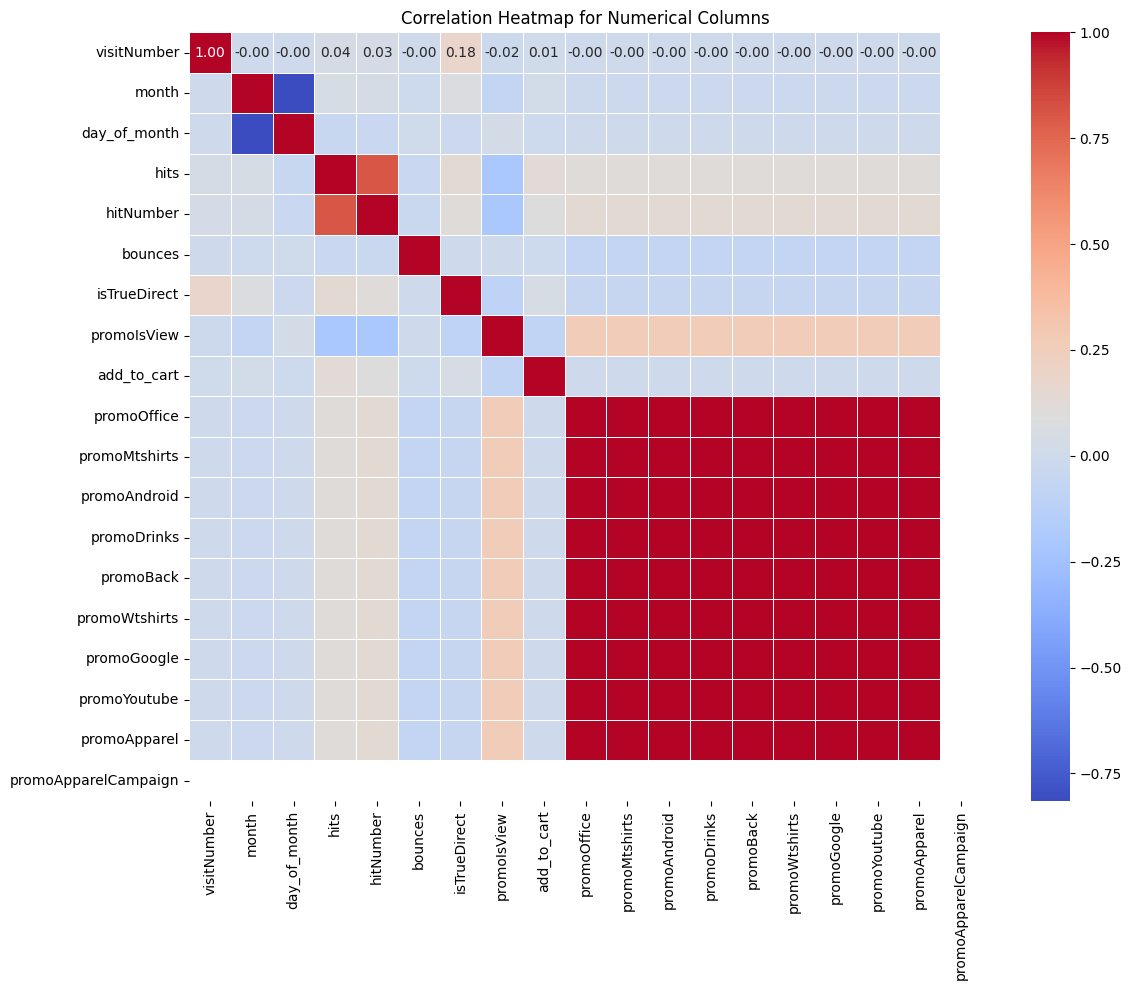

In [29]:
# Plot heatmap for numerical columns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Numerical Columns')
plt.tight_layout()
plt.show()

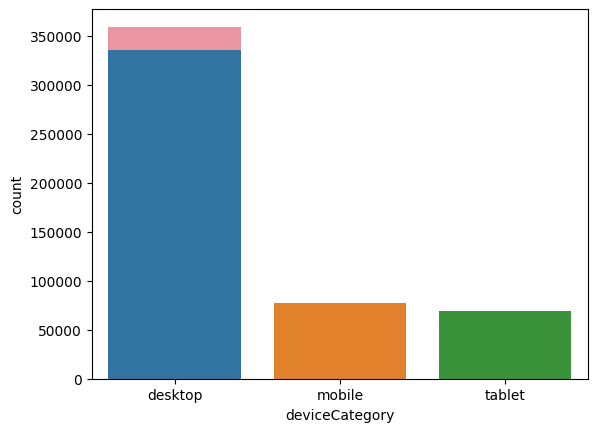

In [30]:
# Countplots for Categorical Columns:
for column in categorical_df.columns:
    sns.countplot(data=categorical_df, x=column)

Feature Selection / Engineering:

1. Select relevant features that might influence the "Add to Cart" action
2. Perform Feature Engineering to create new features if necessary (e.g. combining or transforming existing features)
3. Use domain knowledge and insights gained from EDA to guide feature selection and engineering

In [31]:
# One-Hot Encoding - # Leave out session ID, because this doesn't actually have data to be inferred upon. It's an ID. 

# List of columns to encode:
columns_to_encode = ['medium', 'source', 'channelGrouping', 'deviceCategory']

# Perform one-hot encoding for each column
one_hot_encoded = pd.get_dummies(selectData_bq_df[columns_to_encode])


In [32]:
# Concatenate the one-hot encoded columns with the original DataFrame:
encoded_df = pd.concat([selectData_bq_df, one_hot_encoded], axis=1)

# Drop the original categorical columns, they serve no purpose now and will not be used in the models
encoded_df.drop(columns = columns_to_encode, inplace=True)


In [33]:
# Get list of all column names after one-hot encoding
encoded_column_names = encoded_df.columns.tolist()

# Display the list of encoded column names
print(encoded_column_names)

['session_id', 'visitNumber', 'month', 'day_of_month', 'hits', 'hitNumber', 'visits', 'bounces', 'isTrueDirect', 'social_Engagement', 'promoIsView', 'add_to_cart', 'promoOffice', 'promoLeather', 'promoElectro', 'promoMtshirts', 'promoFruit', 'promoAndroid', 'promoDrinks', 'promoOfficeCampaign', 'promoPenPencilHigh', 'promoLifestyle', 'promoAccessories', 'promoEngravedCeramic', 'promoBack', 'promoWtshirts', 'promoGoogle', 'promoYoutube', 'promoApparel', 'promoApparelCampaign', 'medium_(none)', 'medium_affiliate', 'medium_cpm', 'medium_organic', 'medium_referral', 'source_(direct)', 'source_Partners', 'source_adwords.google.com', 'source_amazon.com', 'source_analytics.google.com', 'source_aol', 'source_arstechnica.com', 'source_ask', 'source_baidu', 'source_bing', 'source_blog.golang.org', 'source_col128.mail.live.com', 'source_connect.googleforwork.com', 'source_course.fso.fullsail.edu', 'source_dailydot.com', 'source_dealspotr.com', 'source_dfa', 'source_digg.com', 'source_docs.google.

In [34]:
# Min-Max Scaling - Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Extract the features to be scaled (exclude non-numerics which is session id, typically a randomly assigned integer that has no inherent value)
features_to_scale = encoded_df.drop(columns=['session_id'])

In [35]:
# Fit the scaler to the features and transform the data
scaled_features = scaler.fit_transform(features_to_scale)

In [36]:
# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Display the scaled features 
print(scaled_df)

        visitNumber  month  day_of_month      hits  hitNumber  visits  \
0               0.0    0.0      1.000000  0.056140   0.000000     0.0   
1               0.0    0.0      1.000000  0.056140   0.003509     0.0   
2               0.0    0.0      1.000000  0.056140   0.007018     0.0   
3               0.0    0.0      1.000000  0.056140   0.010526     0.0   
4               0.0    0.0      1.000000  0.056140   0.014035     0.0   
...             ...    ...           ...       ...        ...     ...   
428281          0.0    0.0      0.827586  0.021053   0.007018     0.0   
428282          0.0    0.0      0.827586  0.021053   0.010526     0.0   
428283          0.0    0.0      0.827586  0.021053   0.014035     0.0   
428284          0.0    0.0      0.827586  0.021053   0.017544     0.0   
428285          0.0    0.0      0.827586  0.021053   0.021053     0.0   

        bounces  isTrueDirect  social_Engagement  promoIsView  ...  \
0           0.0           0.0                0.0     

In [37]:
## Feature Selection -- DO NOT SELECT ALL, OTHERWISE IT'S OVERFITTING

selected_features = [
    #From the Original Data Featues
    'hits', 'hitNumber', 'isTrueDirect', 'social_Engagement', 
    'promoIsView', 'promoOffice','promoLeather','promoElectro','promoMtshirts', 'promoFruit', 
    'promoAndroid', 'promoDrinks', 'promoOfficeCampaign', 'promoPenPencilHigh', 'promoLifestyle', 
    'promoAccessories', 'promoEngravedCeramic', 'promoBack', 'promoWtshirts', 'promoGoogle', 'promoYoutube', 
    'promoApparel', 'promoApparelCampaign',
    
    #Adding the One-Hot Encoding Features
    'medium_(none)', 'medium_affiliate', 'medium_cpm', 'medium_organic', 'medium_referral', 'source_(direct)', 'channelGrouping_Affiliates', 
    'channelGrouping_Direct', 'channelGrouping_Display', 'channelGrouping_Organic Search', 'channelGrouping_Paid Search', 'channelGrouping_Referral', 
    'channelGrouping_Social', 'deviceCategory_desktop', 'deviceCategory_mobile', 'deviceCategory_tablet'

]

Model Selection and Training:

1. Choose appropriate machine learning models for binary classification (e.g. Logistic Regression, Random Forest, GB)
2. Train different models on the training dataset
3. Evaluate models using appropriate evaluation metrics (e.g. accuracy precision, recall, F1-score)
4. Optimize hyperparameters using techniques like grid search or random search


In [38]:
## Split the Data into features (X) and Target Variable (y)
X = scaled_df[selected_features]
y = scaled_df['add_to_cart']     # the target is the eCommerce action_type "Add to Cart"

In [39]:
## Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)

Model Evaluation and Tuning: 

1. Evaluate the trained models on the testing dataset
2. Analyze model performance using evaluation metrics and confusion matrices
3. Fine-tune the models based on the evaluation results
4. Iterate on feature selection, engineering, and model training if necessary


In [40]:
# Logistic Regression Model - Initializing

log_reg_model = LogisticRegression()


In [41]:
# Fit the logistic regression model to the training data "Train the Model"

log_reg_model.fit(X_train, y_train)


LogisticRegression()

In [42]:
# Now that the model is trained, make predictions

y_pred = log_reg_model.predict(X_test)


In [43]:
# Evaluate the model, calculate accuracy:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9713370442319187


In [45]:
# Generate classification report:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    104003
         1.0       1.00      0.00      0.00      3069

    accuracy                           0.97    107072
   macro avg       0.99      0.50      0.49    107072
weighted avg       0.97      0.97      0.96    107072



In [46]:
# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[104003      0]
 [  3069      0]]


In [47]:
# Hyperparameter tuning for the Logistic Regression Model
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty':['l2']}


In [48]:
# Perform grid search cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
             scoring='accuracy')

In [49]:
# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}


In [50]:
# Now, need to re-train the model with the best hyperparams
best_log_reg_model = LogisticRegression(**best_params)
best_log_reg_model.fit(X_train, y_train)

LogisticRegression(C=0.01)

In [51]:
# Make predictions on the newly tuned model
y_pred_tuned = best_log_reg_model.predict(X_test)

In [52]:
# Evaluate the tuned model
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print("Tuned Log Reg Model Accuracy", tuned_accuracy)

Tuned Log Reg Model Accuracy 0.9713370442319187


In [53]:
# Compute the F1-score:
f1 = f1_score(y_test, y_pred_tuned)

In [54]:
# Print F1 score
print("F1-score:", f1)  

# Got the worst score possible, meaning either precision or recall are zero. 
# This could be happen from Imbalanced Dataset, Model Bias or Underfiting, Data Quality Issues, or Incorrect Model Selection, this is why we have
# to continue trying other models and iterating through different features selections. 

F1-score: 0.0


Deployment:

1. Deploy the trained model to Google Cloud Platform (GCP) using VertexAI or any other suitable service
2. Document the deployment process, including all necessary steps for redeployment.
3. Ensure the deployed model can respond to prediction requests efficiently

In [ ]:
-- Shifting Approach to Google Cloud Platform --